In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device(type='cuda')

In [3]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

--2024-08-10 05:57:34--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  10.9MB/s    in 5.1s    

2024-08-10 05:57:40 (9.96 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPe

In [4]:
from matplotlib import pyplot as plt
from torchvision.io import read_image
import os
import numpy as np

image = read_image("data/PennFudanPed/PNGImages/FudanPed00001.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00001_mask.png")
print(image.shape, mask.shape)

torch.Size([3, 536, 559]) torch.Size([1, 536, 559])


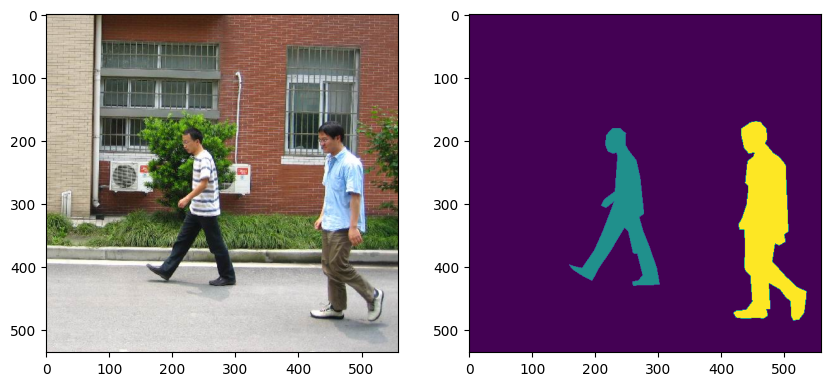

In [5]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(mask.permute(1,2,0))
plt.show()

**DATASET INFO**

image: torchvision.tv_tensors.Image of shape [3, H, W], a pure tensor, or a PIL Image of size (H, W)

target: a dict containing the following fields

boxes, torchvision.tv_tensors.BoundingBoxes of shape [N, 4]: the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H

labels, integer torch.Tensor of shape [N]: the label for each bounding box. 0 represents always the background class.

image_id, int: an image identifier. It should be unique between all the images in the dataset, and is used during evaluation

area, float torch.Tensor of shape [N]: the area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.

iscrowd, uint8 torch.Tensor of shape [N]: instances with iscrowd=True will be ignored during evaluation.

(optionally) masks, torchvision.tv_tensors.Mask of shape [N, H, W]: the segmentation masks for each one of the objects

In [6]:
from torchvision.ops import masks_to_boxes
from torch.utils.data import Dataset, DataLoader
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class PennFudanDataset():
  def __init__(self, root, transforms):
    self.root = root
    self.transforms = transforms

    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

  def __getitem__(self, i):
    img_path = os.path.join(self.root, "PNGImages", self.imgs[i])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[i])
    img = read_image(img_path)
    mask = read_image(mask_path)

    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:]
    num_objs = len(obj_ids)
    masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

    boxes = masks_to_boxes(masks)

    labels = torch.ones((num_objs,), dtype=torch.int64)

    image_id = i
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # Wrap sample and targets into torchvision tv_tensors:
    img = tv_tensors.Image(img)

    target = {}
    target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
    target["masks"] = tv_tensors.Mask(masks)
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

Fine-tuning from pre-trained model (resnet50 backbone)

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 2 #person + background

#number of input features
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 67.4MB/s]


Modifying the model to a different backbone (mobilenet v2)

In [8]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 64.2MB/s]


Utilizing Mask R-CNN which extends extends Faster R-CNN producing a class label, bounding-box offset and object mask.

In [9]:
def get_model_image_segmentation(num_classes):

  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256

  model.roi_heads.mask_predictor = MaskRCNNPredictor (in_features_mask, num_classes, hidden_layer)

  return model


In [10]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

Image Augmentation

In [11]:
from torchvision.transforms import v2 as T

def get_transform(train):
  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  transforms.append(T.ToDtype(torch.float, scale=True))
  transforms.append(T.ToPureTensor())
  return T.Compose(transforms)

Generating output for a subset (testing only)

In [19]:
from torch.utils.data import DataLoader
import utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_model_image_segmentation(num_classes)

ped_dataset = PennFudanDataset("/content/data/PennFudanPed", get_transform(train=True))
data_loader = DataLoader(dataset=ped_dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

#get 2 images
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k:v for k,v in t.items()} for t in targets]
output = model(images, targets)
print(output)

model.eval()
x = [torch.randn(3, 350, 450), torch.randn(3, 250, 150)]
predictions = model(x)
print(predictions[0])


{'loss_classifier': tensor(0.7590, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1774, grad_fn=<DivBackward0>), 'loss_mask': tensor(0.7003, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.0133, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0021, grad_fn=<DivBackward0>)}
{'boxes': tensor([[0.0000e+00, 7.9534e+01, 2.4574e+00, 8.7408e+01],
        [4.4280e-01, 7.9517e+01, 4.5670e+00, 8.7513e+01],
        [6.0612e-01, 1.5664e+02, 4.8967e+00, 1.6296e+02],
        [3.9710e-01, 2.8773e+02, 4.7379e+00, 2.9494e+02],
        [1.3592e+00, 2.2120e+02, 3.8736e+01, 3.2346e+02],
        [1.0694e+02, 2.6823e+02, 1.1226e+02, 2.7383e+02],
        [0.0000e+00, 5.9445e+01, 2.2246e+01, 1.1104e+02],
        [0.0000e+00, 2.8813e+02, 2.4585e+01, 3.4443e+02],
        [2.8899e+02, 7.9896e+01, 3.1529e+02, 1.0610e+02],
        [1.5879e+02, 4.7756e+01, 1.6321e+02, 5.2260e+01],
        [1.4353e+00, 7.7556e+00, 3.8641e+01, 8.7476e+01],
        [2

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
model = get_model_image_segmentation(num_classes)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 214MB/s]


In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from engine import evaluate
import utils

dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

split_index = int(0.8 * len(dataset))

indices = torch.randperm(len(dataset)).tolist()

train_indices = indices[:split_index]
test_indices = indices[split_index:]

dataset = torch.utils.data.Subset(dataset, train_indices)
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

train_data_loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)
test_data_loader = DataLoader(dataset=dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

print(f'Number of training samples: {len(train_data_loader.dataset)}')
print(f'Number of training batches: {len(train_data_loader)}')
print(f'Number of test samples: {len(test_data_loader.dataset)}')
print(f'Number of test batches: {len(test_data_loader)}')

num_epochs = 2
lr = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model.to(device)

for epoch in range(num_epochs):

  for images, targets in train_data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: torch.tensor(v).to(device) for k,v in t.items()} for t in targets]
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item():.4f}")

  evaluate(model, test_data_loader, device=device)


Number of training samples: 136
Number of training batches: 68
Number of test samples: 34
Number of test batches: 34


<ipython-input-20-11272ea59794>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k,v in t.items()} for t in targets]


AttributeError: 'list' object has no attribute 'values'

In [21]:
from engine import train_one_epoch, evaluate
import utils

dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

split_index = int(0.8 * len(dataset))

indices = torch.randperm(len(dataset)).tolist()

train_indices = indices[:split_index]
test_indices = indices[split_index:]

dataset = torch.utils.data.Subset(dataset, train_indices)
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

train_data_loader = DataLoader(dataset=dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)
test_data_loader = DataLoader(dataset=dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

lr = 0.0001

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    # train for one epoch
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # evaluate on the test dataset
    evaluate(model, test_data_loader, device=device)


Epoch: [0]  [ 0/68]  eta: 0:00:16  lr: 0.000002  loss: 0.6618 (0.6618)  loss_classifier: 0.0553 (0.0553)  loss_box_reg: 0.1410 (0.1410)  loss_mask: 0.4603 (0.4603)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0042 (0.0042)  time: 0.2425  data: 0.0183  max mem: 13425
Epoch: [0]  [10/68]  eta: 0:00:12  lr: 0.000017  loss: 0.6225 (0.5903)  loss_classifier: 0.0389 (0.0400)  loss_box_reg: 0.1057 (0.0965)  loss_mask: 0.4507 (0.4484)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0047 (0.0047)  time: 0.2188  data: 0.0191  max mem: 13875
Epoch: [0]  [20/68]  eta: 0:00:10  lr: 0.000031  loss: 0.5903 (0.5917)  loss_classifier: 0.0389 (0.0461)  loss_box_reg: 0.1051 (0.1010)  loss_mask: 0.4255 (0.4368)  loss_objectness: 0.0005 (0.0023)  loss_rpn_box_reg: 0.0052 (0.0055)  time: 0.2180  data: 0.0219  max mem: 14380
Epoch: [0]  [30/68]  eta: 0:00:08  lr: 0.000046  loss: 0.5866 (0.5760)  loss_classifier: 0.0382 (0.0440)  loss_box_reg: 0.0868 (0.0948)  loss_mask: 0.4110 (0.4301)  loss

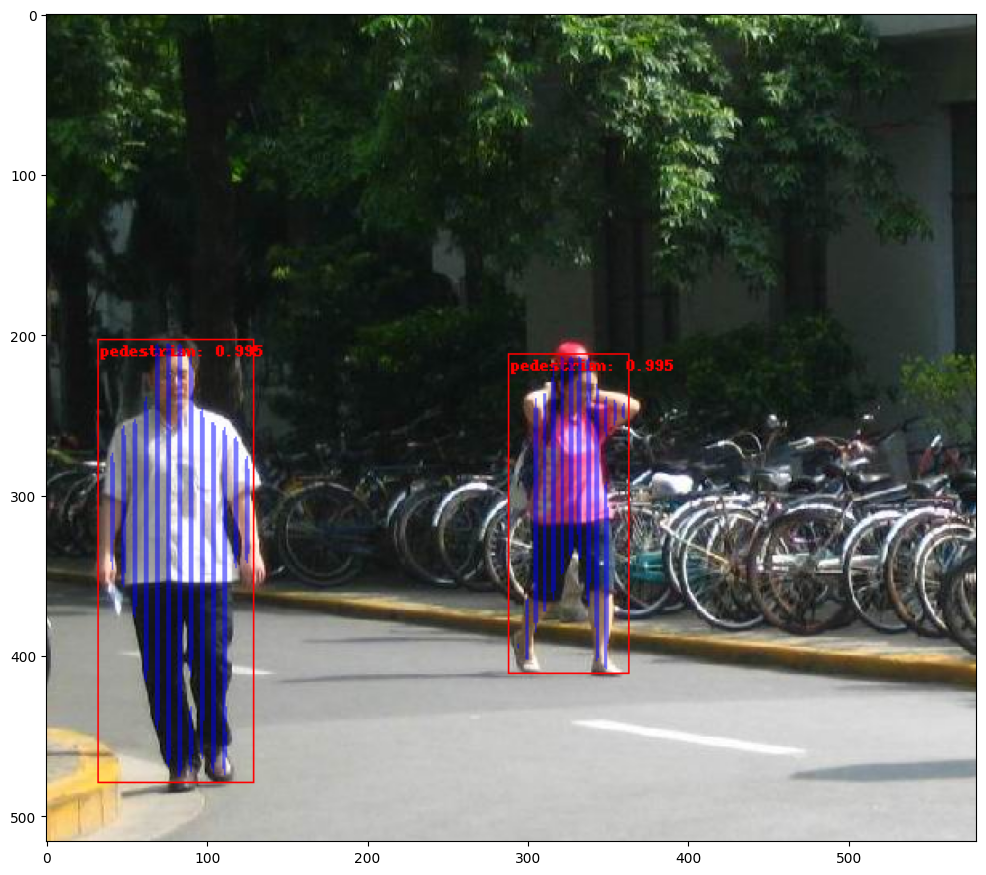

In [24]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("/content/data/PennFudanPed/PNGImages/FudanPed00050.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [26]:
!git config --global user.email "61135837+t-tauri99@users.noreply.github.com"
!git config --global user.name "t-tauri99"

In [28]:
!git clone https://github.com/t-tauri99/Deep-Learning-with-PyTorch.git

Cloning into 'Deep-Learning-with-PyTorch'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 1), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (8/8), 19.65 KiB | 19.65 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [31]:
!pwd

/content/Deep-Learning-with-PyTorch


In [32]:
!mkdir CV

In [33]:
%cd CV

/content/Deep-Learning-with-PyTorch/CV


In [ ]:
!cp '/content/drive/MyDrive/Colab\ Notebooks/' nn-pytorch.ipynb' .

In [ ]:
/content/drive/MyDrive/Colab Notebooks/Object Detection Fine-Tuning with Mask R-CNN.ipynb